In [45]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Create vanilla results dataframe from the provided data
testset_name = "finals_serial"

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']
    if 'master_echelon' in reference_row:
        out_row['master_echelon'] = reference_row['master_echelon']

def default_condition_setter(condition_name):
    return None

# Define color scheme, line styles and markers
color_scheme = {
    128: "#1f77b4",    # Blue
    1024: "#2ca02c",   # Green
    8192: "#ff7f0e",   # Orange
}

marker_scheme = {
    128: "o",          # Blue Circle
    1024: "v",         # Green Downward Triangle
    8192: "s",         # Orange Rectangle
}

linestyle_scheme = {
    "GNN": "-",          # Solid
    "Vanilla": "--",  # Dashed
}

# Define paths for each architecture
architectures = {
    "Vanilla": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
    "echelon_stock_hard": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard',
    "GNN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

configs = ["serial_system_3", "serial_system_4", "serial_system_5", "serial_system_6", "serial_system_7"]
sample_sizes = [128, 1024, 8192]

dfs = []

for arch_name, path_fn in architectures.items():
    path = path_fn(None)
    paths = {1: path}
    df = results_interpretor.make_table(
        paths,
        {
            'train_dev_sample_and_batch_size': sample_sizes,
            'store_underage_cost': [9],
            'store_lead_time': [4],
            'samples': [1],
            'config': configs,
        },
        default_condition_setter,
        custom_data_filler,
        sort_by=sort_by,
        pick_row_from_run_by=pick_row_from_run_by,
        test_loss_limit=25
    )
    if df.empty:
        continue

    df['system_length'] = df['config'].apply(lambda c: int(str(c).split('_')[-1]))
    df.insert(2, 'Architecture Class', arch_name)
    df.insert(1, 'hyperparam_name', arch_name)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

import numpy as np

test_loss_column = 'Test Loss'

test_losses = []
for _, row in df.iterrows():
    test_loss_path = str(row['path']) + "/" + row['config'] + "_5000_test_loss.txt"
    try:
        with open(test_loss_path, 'r') as f:
            value = float(f.read().strip())
    except Exception:
        value = np.nan
    test_losses.append(value)

df[test_loss_column] = test_losses

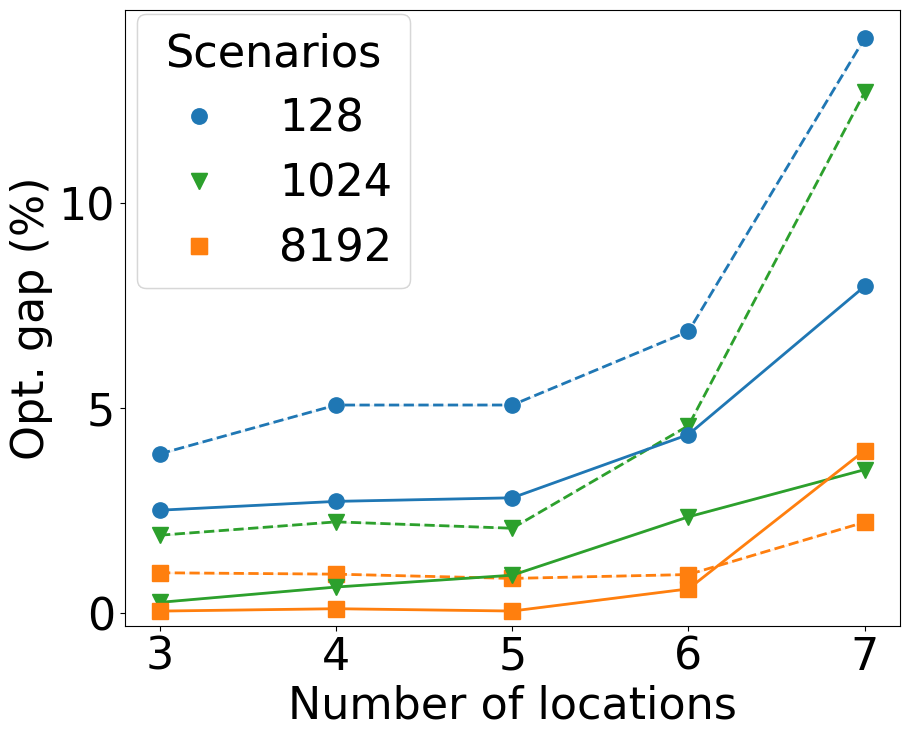

In [47]:

# Get optimal losses from echelon_stock_hard with 8K samples
optimal_losses = {}
for config in configs:
    system_length = int(config.split('_')[-1])
    optimal_data = df[(df['Architecture Class'] == 'echelon_stock_hard') & 
                      (df['train_dev_sample_and_batch_size'] == 8192) & 
                      (df['config'] == config)]
    if not optimal_data.empty:
        optimal_losses[system_length] = optimal_data['Test Loss'].min()

# Calculate optimality gap percentage using echelon_stock_hard policy's test losses with 8K samples
stats_by_arch_sample_and_system_length = {}
for system_length, optimal_loss in optimal_losses.items():
    system_data = df[df['system_length'] == system_length].copy()
    
    # Skip echelon_stock_hard policy in the plot
    system_data = system_data[system_data['Architecture Class'] != 'echelon_stock_hard']
    
    if system_data.empty:
        continue
        
    system_data.loc[:, 'Gap %'] = ((system_data['Test Loss'] - optimal_loss) / optimal_loss) * 100
    
    for arch in system_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_system_length:
                stats_by_arch_sample_and_system_length[key] = []
                
            sample_data = system_data[(system_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (system_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_system_length[key].append({
                    'system_length': system_length,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

FONTSIZE = 32
MARKERSIZE = 11
LINEWIDTH = 2
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

for (arch, sample_size), stats in stats_by_arch_sample_and_system_length.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        system_length_array = stats_df['system_length'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(system_length_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle=linestyle_scheme[arch],
                markersize=MARKERSIZE,
                linewidth=LINEWIDTH)
        
        plt.fill_between(system_length_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch, linewidth=LINEWIDTH) 
              for arch in linestyle_scheme.keys()]
sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=MARKERSIZE, linewidth=LINEWIDTH)
                 for size in color_scheme.keys()]

plt.xlabel('Number of locations', fontsize=FONTSIZE)
plt.ylabel('Opt. gap (%)', fontsize=FONTSIZE)
plt.xticks(range(3, 8), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# legend1 = plt.legend(handles=arch_lines, 
#                     bbox_to_anchor=(0.79, 1),
#                     loc='upper right', 
#                     fontsize=FONTSIZE,
#                     borderaxespad=0.1,
#                     framealpha=0.6)
# plt.gca().add_artist(legend1)

plt.gca().set_ylim(bottom=-0.3)
legend2 = plt.legend(handles=sample_patches,
                    title='Scenarios',
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE,
                    borderaxespad=0.1,
                    framealpha=0.6)
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

#plt.tight_layout()

plot_filename = "/user/ml4723/Prj/NIC/Plots/sample_efficiency_serial.pdf"
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()


In [ ]:
# Create a df table with “Number of locations, Training scenarios (#), Architecture Class, Learning rate, Units per layer (#), Train loss, Dev loss, Test loss, Test optimality gap (%)” columns from current df.

# Test optimality gap (%) is calculated by comparing to optimal loss in its number of locations, which is echelon_stock_hard’s losses.

# if values does not exist for the column, fill it by -.

# round losses or gaps up to 2nd decimal.

# change Vanilla NN architecture class name to just Vanilla.

# sort the datafram by Number of stores, Training scenarios, and Architecture Class (GNN and then Vanilla).

# For each number of locations, pick the row with lowest Relative test loss in and wrap only its test loss by \textbf{}. 

# Units per layer (#) is ‘master_echelon’.

# current df has columns:

# complete this table:

# \begin{tabular}{>{\raggedleft}p{1.9cm}>{\raggedleft}p{2.3cm}>{\raggedleft}p{2.0cm}>{\raggedleft}p{1.3cm}>{\raggedleft}p{1.6cm}>{\raggedleft}p{0.7cm}>{\raggedleft}p{0.7cm}>{\raggedleft}p{0.7cm}>{\raggedleft\arraybackslash}p{1.6cm}}
# \toprule
# .For each change of Number of locations, put \midrule. ignore index. with this data. keep the same column names:

In [29]:
# Prepare optimal losses for each system length (number of locations) using echelon_stock_hard
optimal_losses = {}
for system_length in df['system_length'].dropna().unique():
    system_length = int(system_length)
    opt_rows = df[
        (df['Architecture Class'] == 'echelon_stock_hard') &
        (df['system_length'] == system_length)
    ]
    if not opt_rows.empty:
        min_loss = opt_rows['Test Loss'].min()
        optimal_losses[system_length] = round(min_loss, 2)

output_rows = []
for idx, row in df.iterrows():
    arch = row.get('Architecture Class', '-')
    if arch == 'Vanilla NN':
        arch = 'Vanilla'
    if arch not in ['GNN', 'Vanilla']:
        continue

    num_locations = int(row['system_length']) if not pd.isnull(row['system_length']) else '-'
    train_scenarios = int(row['train_dev_sample_and_batch_size']) if not pd.isnull(row['train_dev_sample_and_batch_size']) else '-'
    learning_rate = row['Learning Rate'] if 'Learning Rate' in row and not pd.isnull(row['Learning Rate']) else '-'
    units_per_layer = int(row['master_echelon']) if 'master_echelon' in row and not pd.isnull(row['master_echelon']) else '-'

    train_loss = row['Train Loss'] if 'Train Loss' in row and not pd.isnull(row['Train Loss']) else '-'
    dev_loss = row['Dev Loss'] if 'Dev Loss' in row and not pd.isnull(row['Dev Loss']) else '-'
    test_loss = row['Test Loss'] if 'Test Loss' in row and not pd.isnull(row['Test Loss']) else '-'

    if train_loss != '-' and isinstance(train_loss, (float, int)):
        train_loss = round(train_loss, 2)
    if dev_loss != '-' and isinstance(dev_loss, (float, int)):
        dev_loss = round(dev_loss, 2)
    if test_loss != '-' and isinstance(test_loss, (float, int)):
        test_loss = round(test_loss, 2)

    if num_locations != '-' and num_locations in optimal_losses and test_loss != '-':
        test_gap = ((test_loss - optimal_losses[num_locations]) / optimal_losses[num_locations]) * 100
        test_gap = round(test_gap, 2)
    else:
        test_gap = '-'

    output_rows.append({
        'Number of locations': num_locations,
        'Training scenarios (#)': train_scenarios,
        'Architecture Class': arch,
        'Learning rate': learning_rate,
        'Units per layer (#)': units_per_layer,
        'Train loss': train_loss,
        'Dev loss': dev_loss,
        'Test loss': test_loss,
        'Test Optimality Gap (%)': test_gap
    })

df_out = pd.DataFrame(output_rows)

arch_order = {'GNN': 0, 'Vanilla': 1}
df_out['arch_sort'] = df_out['Architecture Class'].map(arch_order)
df_out = df_out.sort_values(
    by=['Number of locations', 'Training scenarios (#)', 'arch_sort'],
    ascending=[True, True, True]
).reset_index(drop=True)
df_out = df_out.drop(columns=['arch_sort'])

for num_locations in df_out['Number of locations'].unique():
    if num_locations == '-':
        continue
    subset = df_out[df_out['Number of locations'] == num_locations]
    subset_numeric = subset[pd.to_numeric(subset['Test Optimality Gap (%)'], errors='coerce').notnull()]
    if not subset_numeric.empty:
        min_idx = subset_numeric['Test Optimality Gap (%)'].astype(float).idxmin()
        val = df_out.at[min_idx, 'Test loss']
        if not (isinstance(val, str) and val.startswith(r"\textbf{")):
            df_out.at[min_idx, 'Test loss'] = r"\textbf{" + str(val) + "}"

print(df_out.to_string(index=False))

 Number of locations  Training scenarios (#) Architecture Class  Learning rate Units per layer (#)  Train loss  Dev loss      Test loss  Test Optimality Gap (%)
                   3                     128                GNN         0.0010                   -        9.76     10.10          10.11                     2.43
                   3                     128            Vanilla         0.0100                 128       10.02     10.13          10.25                     3.85
                   3                    1024                GNN         0.0100                   -        9.94      9.94           9.89                     0.20
                   3                    1024            Vanilla         0.0100                  64       10.10     10.10          10.05                     1.82
                   3                    8192                GNN         0.0010                   -        9.92      9.89  \textbf{9.87}                     0.00
                   3              

/var/folders/s0/h372zwws2xl0yflc5w4m85j00000gn/T/ipykernel_22006/1591515581.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{9.87}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.at[min_idx, 'Test loss'] = r"\textbf{" + str(val) + "}"


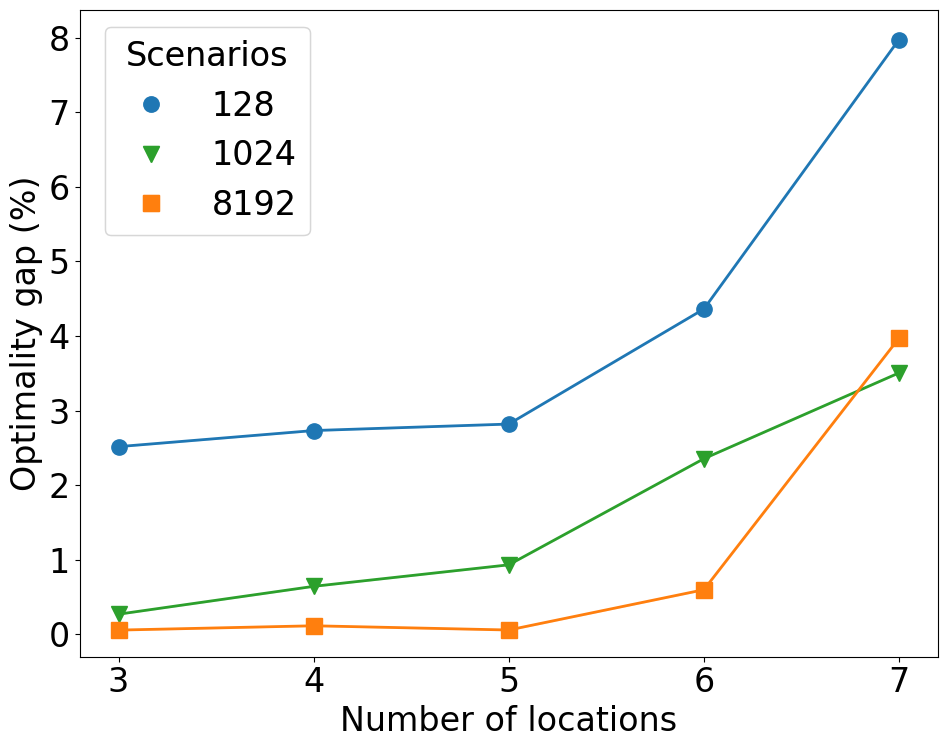

In [44]:

# Get optimal losses from echelon_stock_hard with 8K samples
optimal_losses = {}
for config in configs:
    system_length = int(config.split('_')[-1])
    optimal_data = df[(df['Architecture Class'] == 'echelon_stock_hard') & 
                      (df['train_dev_sample_and_batch_size'] == 8192) & 
                      (df['config'] == config)]
    if not optimal_data.empty:
        optimal_losses[system_length] = optimal_data['Test Loss'].min()

gnn_label = 'GNN'

stats_by_arch_sample_and_system_length = {}
for system_length, optimal_loss in optimal_losses.items():
    system_data = df[(df['system_length'] == system_length) & 
                     (df['Architecture Class'] == gnn_label)].copy()
    
    if system_data.empty:
        continue
        
    system_data.loc[:, 'Gap %'] = ((system_data['Test Loss'] - optimal_loss) / optimal_loss) * 100
    
    for arch in system_data['Architecture Class'].unique():
        for sample_size in sample_sizes:
            key = (arch, sample_size)
            if key not in stats_by_arch_sample_and_system_length:
                stats_by_arch_sample_and_system_length[key] = []
                
            sample_data = system_data[(system_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                   (system_data['Architecture Class'] == arch)]
            if not sample_data.empty:
                gaps = sample_data['Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_arch_sample_and_system_length[key].append({
                    'system_length': system_length,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

FONTSIZE = 24
MARKERSIZE = 11
LINEWIDTH = 2

plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': FONTSIZE})

for (arch, sample_size), stats in stats_by_arch_sample_and_system_length.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        system_length_array = stats_df['system_length'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(system_length_array, mean_gap_array,
                marker=marker_scheme[sample_size],
                color=color_scheme[sample_size],
                linestyle='-',
                markersize=MARKERSIZE,
                linewidth=LINEWIDTH)
        
        plt.fill_between(system_length_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[sample_size],
                        alpha=0.1)

sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                            linestyle='none', label=f'{size}', markersize=MARKERSIZE, linewidth=LINEWIDTH)
                 for size in color_scheme.keys()]

plt.xlabel('Number of locations', fontsize=FONTSIZE)
plt.ylabel('Optimality gap (%)', fontsize=FONTSIZE)
plt.xticks(range(3, 8), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.ylim(bottom=-0.3)

plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1))

legend2 = plt.legend(handles=sample_patches,
                    bbox_to_anchor=(0.01, 1),
                    loc='upper left',
                    fontsize=FONTSIZE,
                    markerscale=1,
                    framealpha=0.6,
                    title="Scenarios")
plt.gca().add_artist(legend2)
legend2.get_title().set_fontsize(FONTSIZE)

plt.tight_layout()
plt.savefig('/user/ml4723/Prj/NIC/Plots/optimality_serial_GNN.pdf', bbox_inches='tight')

plt.show()

In [31]:
df_table = df
columns_to_remove = [
    '# of stores',
    'hyperparam_name',
    # 'Architecture Class',
    'store_underage_cost',
    'store_lead_time',
    'samples',
    'config',
    'path',
    'Learning Rate'
]
df_table = df_table.drop(columns=[col for col in columns_to_remove if col in df_table.columns])


optimal_losses = {}
for config in configs:
    system_length = int(config.split('_')[-1])
    optimal_data = df[(df['Architecture Class'] == 'echelon_stock_hard') & 
                      (df['train_dev_sample_and_batch_size'] == 8192) & 
                      (df['config'] == config)]
    if not optimal_data.empty:
        optimal_losses[system_length] = optimal_data['Test Loss'].min()

df_table = df_table[df_table["Architecture Class"] != 'echelon_stock_hard']
df_table = df_table[df_table["Architecture Class"] != 'Vanilla NN']

# Calculate test loss gap using optimal_losses
def get_test_loss_gap(row):
    system_length = row['system_length']
    optimal_loss = optimal_losses.get(system_length, None)
    if optimal_loss is not None:
        return (row['Test Loss'] - optimal_loss) / optimal_loss * 100
    else:
        return None

df_table['Test Loss Gap'] = df_table.apply(get_test_loss_gap, axis=1)

sample_sizes = [128, 1024, 8192]
summary_rows = []
for sample_size in sample_sizes:
    subset = df_table[df_table['train_dev_sample_and_batch_size'] == sample_size]
    avg_gap = subset['Test Loss Gap'].mean()
    min_gap = subset['Test Loss Gap'].min()
    max_gap = subset['Test Loss Gap'].max()
    summary_rows.append({
        'Sample Size': sample_size,
        'Avgerage opt. gap': avg_gap,
        'Max opt. gap': max_gap
    })
summary_df = pd.DataFrame(summary_rows)
summary_df


,Sample Size,Avgerage opt. gap,Max opt. gap
0,128,4.080450,7.973685
1,1024,1.541057,3.504770
2,8192,0.959800,3.970744


In [4]:
mode = "test"

gpus = [1, 2, 5, 7]

def run_main_run(model_path, setting_name, gpu_idx):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            str(model_path),
            str(gpus[gpu_idx])
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    gpu_idx = 0
    for _, row in df.iterrows():
        path = str(row['path']) + '/model.pt'
        while len(futures) >= 4*len(gpus):
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, row['config'] + '_5000', gpu_idx))
        gpu_idx = (gpu_idx + 1) % len(gpus)
    concurrent.futures.wait(futures)


Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00390_390_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_e_2025-05-09_06-21-10/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00195_195_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_e_2025-05-08_16-36-33/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/ray_results/finals_serial/vanilla_serial/run_2025-05-08_16-36-30/run_1f4d9_00000_0_config=serial_system_3,dev_ignore_periods=60,dev_periods=100,different_for_each_sample=True,early_stop_check_epo_2025-05-08_16-36-31/model.pt
Running main_run.py for path /Users/minuk.lee/Downloads/Neural_inventory_control/r